<a href="https://colab.research.google.com/github/gjduart/NN/blob/main/Python_Notebook_Lab_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load relevant libraries
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

This tutorial is adapted from 
[Classification of Flowers using Tensorflow 2.0](https://www.back-prop.com/deep_learning/inceptionv3/tf_flowers/feature_extraction/fine_tuning/google_colab/2019/05/17/InceptionV3_TFFLOWERS/).

This tutorial will see how we can use TensorFlow and the tf.data to load and classify flowers. The tf.data.Dataset exposes about 224 preprocessed datasets for developers to quickly load and experiment with test datasets. Here, we will be looking at the tf_flowers dataset.



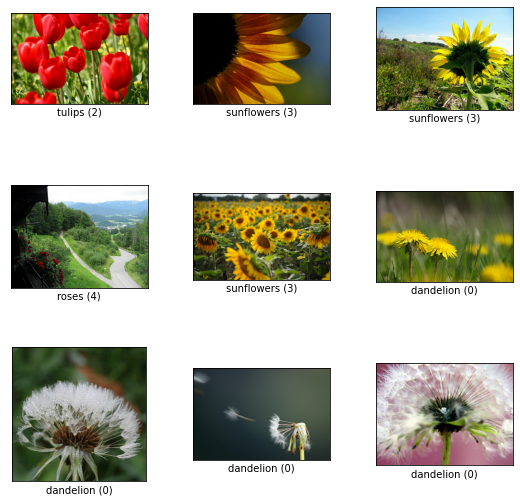

In [ ]:
(ds_train, ds_test, ds_val), ds_info = tfds.load('tf_flowers', split=['train[0%:80%]', 'train[80%:90%]', 'train[90%:100%]'],
    as_supervised=True,  # returns `(img, label)` instead of dict(image=, ...)
    with_info=True,
)

fig = tfds.show_examples(ds_train, ds_info)

In the next step, we will make all the images the same size by resizing them to a 80x80 size and normalizing them by converting all channels to be within 0 and 1. The following function ```adjust_data``` does it all.

Details about caching, shuffling, and prefetching are described [here](https://www.tensorflow.org/datasets/performances) 

In [ ]:
def normalize_and_resize_img(image, label):
  
  image = tf.cast(image, tf.float32)
  
  image = tf.image.resize(image, (80, 80))
  
  image = image / 255.0
  
  return image,label


def adjust_data(ds, num_examples_training=None):
  ds = ds.map(
    normalize_and_resize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  
  if num_examples_training != None:
    ds = ds.cache()
    ds = ds.shuffle(num_examples_training)
    ds = ds.batch(32)
  else:
    ds = ds.batch(32)
    ds = ds.cache()

  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)

  return ds



num_examples = ds_info.splits['train'].num_examples

# adjust each split
ds_train = adjust_data(ds_train, num_examples)
ds_test = adjust_data(ds_test)
ds_val = adjust_data(ds_val)

print('Data pre-processed.')

Data pre-processed.


In the block below, a CNN is defined. It contains an Input layer followed by a couple of convolution layers followed by max-pooling layers, and then finally followed by a couple of dense layers.

In [ ]:
def create_model(num_classes):
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, kernel_size=(3, 3), input_shape=(80, 80, 3), activation='relu'),
      tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
      tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
      tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
      tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(num_classes, activation='softmax')
  ])

  model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],

  )

  return model

Visualizing the CNN and the splits

In [ ]:
n_classes = ds_info.features['label'].num_classes

dl_model = create_model(n_classes)
dl_model.summary()


print('Number of examples in the train set:', ds_train.cardinality().numpy())
print('Number of examples in the validation set:', ds_val.cardinality().numpy())
print('Number of examples in the test set:', ds_test.cardinality().numpy())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 78, 78, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

.numpy()Fitting the model and evaluating its performance.

In [ ]:
# Fit the model (and perform validation on it)
history = dl_model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=20
)


Epoch 1/20
92/92 [==============================] - 41s 31ms/step - loss: 1.4169 - accuracy: 0.3906 - val_loss: 1.1097 - val_accuracy: 0.5341
Epoch 2/20
92/92 [==============================] - 1s 10ms/step - loss: 1.0651 - accuracy: 0.5680 - val_loss: 0.9825 - val_accuracy: 0.5886
Epoch 3/20
92/92 [==============================] - 1s 9ms/step - loss: 0.9553 - accuracy: 0.6200 - val_loss: 1.0106 - val_accuracy: 0.5722
Epoch 4/20
92/92 [==============================] - 1s 9ms/step - loss: 0.8477 - accuracy: 0.6743 - val_loss: 0.9279 - val_accuracy: 0.6294
Epoch 5/20
92/92 [==============================] - 1s 9ms/step - loss: 0.7272 - accuracy: 0.7239 - val_loss: 0.8088 - val_accuracy: 0.6866
Epoch 6/20
92/92 [==============================] - 1s 10ms/step - loss: 0.6013 - accuracy: 0.7788 - val_loss: 0.9251 - val_accuracy: 0.6458
Epoch 7/20
92/92 [==============================] - 1s 9ms/step - loss: 0.5462 - accuracy: 0.7815 - val_loss: 0.8390 - val_accuracy: 0.6894
Epoch 8/20
92/92

OVERFIT, RIGHT??

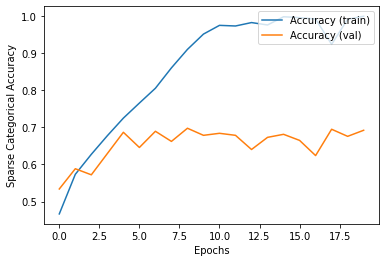

12/12 [==============================] - 1s 42ms/step - loss: 1.9900 - accuracy: 0.6757
loss: 1.990
accuracy: 0.676


In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Accuracy (train)')
plt.plot(history.history['val_accuracy'], label='Accuracy (val)')
plt.legend(loc='upper right')

plt.ylabel('Sparse Categorical Accuracy')
plt.xlabel('Epochs')

plt.show()


results = dl_model.evaluate(ds_test)
for name, value in zip(dl_model.metrics_names, results):
  print("%s: %.3f" % (name, value))


# Your turn...

Now it is time for you to validade some of the learning we had these days.

The goal is to build a robust **DEEP** machine learning model that is able to distinguish between diseases in the Bean plants. Beans are an important cereal food crop for Africa grown by many small-holder farmers - they are a significant source of proteins for school-age going children in East Africa.

The data is of leaf images representing 3 classes: the healthy class of images, and two disease classes including Angular Leaf Spot and Bean Rust diseases. The model should be able to distinguish between these 3 classes with high accuracy. The end goal is to build a robust, model that can be deployed on a mobile device and used in the field by a farmer.

The data includes leaf images taken in the field. The figure above depicts examples of the types of images per class. Images were taken from the field/garden a basic smartphone.

The images were then annotated by experts from NaCRRI who determined for each image which disease was manifested. The experts were part of the data collection team and images were annotated directly during the data collection process in the field.



```
|       Class         | Examples |
----------------------+-----------
|    Healthy class    |    428   |
----------------------+-----------
|  Angular Leaf Spot  |	432   |
----------------------+-----------
|      Bean Rust      |    436   |
----------------------+-----------
|        Total:	   |   1,296  |

```
Data is already divided into Train, Validation, and Test sets.

[Beans dataset](https://www.tensorflow.org/datasets/catalog/beans)


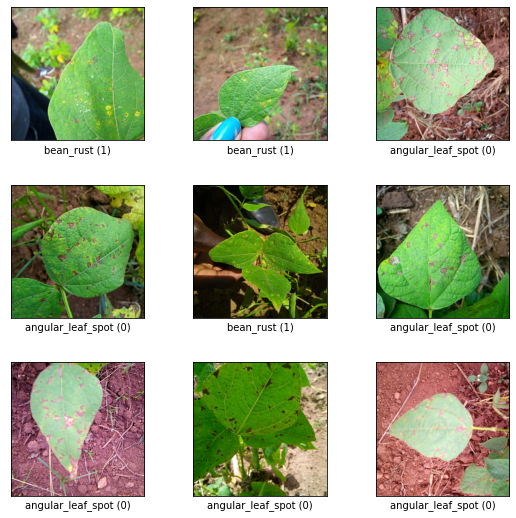

In [ ]:
# Load relevant libraries
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

# Load dataset

(ds_train, ds_test, ds_val), ds_info = tfds.load('beans', split=['train', 'test', 'validation'],
    as_supervised=True,  # returns `(img, label)` instead of dict(image=, ...)
    with_info=True,
)

fig = tfds.show_examples(ds_train, ds_info)

1. Build a classifier.
2. Train it.
3. Show the loss/accuracy from your model.

In [ ]:
image_height, image_width = ds_info.features['image'].shape[0],ds_info.features['image'].shape[1]
num_classes = ds_info.features['label'].num_classes

In [ ]:

def normalize_image(image, label, target_height = 500, target_width = 500):
    #tf.uin8 para float32
    image = tf.cast(image, tf.float32)/255.
    image = tf.image.resize_with_crop_or_pad(image, target_height, target_width)
    return image, label

batch_size = 128

In [ ]:
# Normalizando conjunto de Treino
ds_train = ds_train.map(normalize_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
#Normalizando o conjunto de validacao
ds_val = ds_val.map(normalize_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
ds_val = ds_val.batch(batch_size)
ds_val = ds_val.cache()
ds_val = ds_val.prefetch(tf.data.experimental.AUTOTUNE)

#Normalizando o Conjunto de teste
ds_test = ds_test.map(normalize_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(batch_size)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
#Definindo os Hyper parametros
num_filters = 15
filter_size = 10
pool_size = 4
strides = 2
fc_output = 128
drop_probability = 0.25 #Evitar overfitting
learning_rate = 1e-3

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(num_filters, filter_size, input_shape = (image_height, image_width, 3),
                        strides = strides, padding = 'same', activation = 'relu'),
  tf.keras.layers.MaxPooling2D(pool_size = pool_size),
  tf.keras.layers.Dropout(drop_probability),
  tf.keras.layers.Conv2D(num_filters, filter_size, strides = strides, padding = 'same', 
                         activation = 'relu'),
  tf.keras.layers.MaxPooling2D(pool_size = pool_size),
  tf.keras.layers.Dropout(drop_probability),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(fc_output, activation = 'relu'),

  tf.keras.layers.Dense(num_classes, activation = 'softmax'),
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 250, 250, 15)      4515      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 62, 15)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 62, 62, 15)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 31, 31, 15)        22515     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 15)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 15)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 735)              

In [ ]:
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate),
    metrics = ['accuracy'],
)

num_epochs = 20
history = model.fit(
    ds_train,
    epochs = num_epochs,
    validation_data = ds_val,
)


Epoch 1/20
9/9 [==============================] - 7s 378ms/step - loss: 1.1336 - accuracy: 0.3057 - val_loss: 1.0970 - val_accuracy: 0.3459
Epoch 2/20
9/9 [==============================] - 3s 310ms/step - loss: 1.0957 - accuracy: 0.4020 - val_loss: 1.0921 - val_accuracy: 0.3985
Epoch 3/20
9/9 [==============================] - 3s 312ms/step - loss: 1.0914 - accuracy: 0.3994 - val_loss: 1.0758 - val_accuracy: 0.3609
Epoch 4/20
9/9 [==============================] - 3s 303ms/step - loss: 1.0704 - accuracy: 0.3716 - val_loss: 1.0281 - val_accuracy: 0.5188
Epoch 5/20
9/9 [==============================] - 3s 314ms/step - loss: 0.9938 - accuracy: 0.5103 - val_loss: 0.9806 - val_accuracy: 0.4737
Epoch 6/20
9/9 [==============================] - 3s 311ms/step - loss: 0.9928 - accuracy: 0.5411 - val_loss: 0.9229 - val_accuracy: 0.5865
Epoch 7/20
9/9 [==============================] - 3s 310ms/step - loss: 0.9125 - accuracy: 0.6189 - val_loss: 0.8557 - val_accuracy: 0.5789
Epoch 8/20
9/9 [====

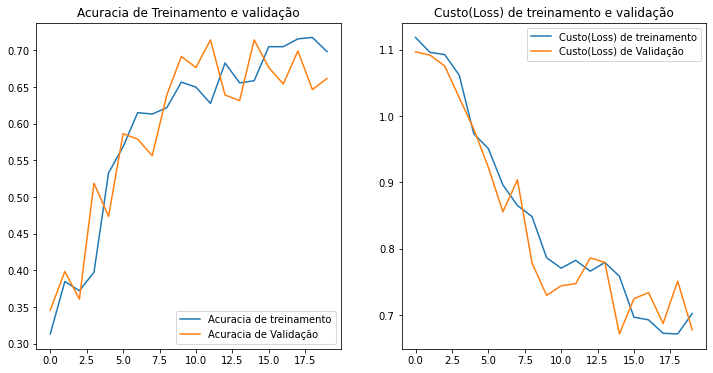

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acuracia de treinamento')
plt.plot(epochs_range, val_acc, label='Acuracia de Validação')
plt.legend(loc='lower right')
plt.title('Acuracia de Treinamento e validação')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Custo(Loss) de treinamento')
plt.plot(epochs_range, val_loss, label='Custo(Loss) de Validação')
plt.legend(loc='upper right')
plt.title('Custo(Loss) de treinamento e validação')
plt.show()